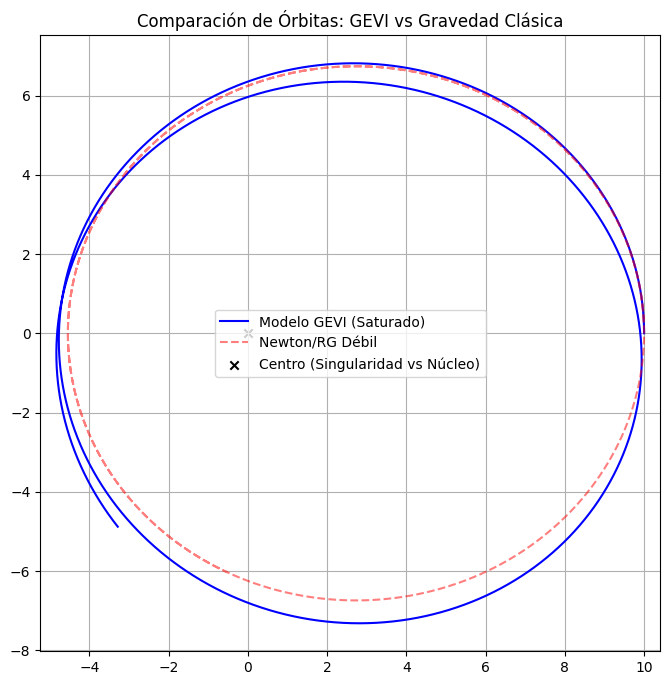

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE LA SIMULACIÓN ---
dt = 0.01          # Paso de tiempo
steps = 20000      # Número de pasos
M_CENTRAL = 1.0    # Masa del objeto central (ej. Sgr A*)
I_CRITICAL = 0.5   # Tu umbral de saturación (v6.1)

# Condiciones iniciales de la estrella (posición y velocidad)
# x, y = 10 unidades de distancia; vx, vy para una órbita casi circular
pos = np.array([10.0, 0.0])
vel = np.array([0.0, 0.25])

# Arrays para guardar la trayectoria
trayectoria_gevi = np.zeros((steps, 2))
trayectoria_newton = np.zeros((steps, 2))

# Copias para comparar ambos modelos
p_gevi, v_gevi = pos.copy(), vel.copy()
p_newton, v_newton = pos.copy(), vel.copy()

# --- BUCLE DE INTEGRACIÓN (LEAPFROG) ---
for i in range(steps):
    # --- MODELO GEVI ---
    # 1. Medio paso de velocidad
    a_g = get_acceleration_gevi(p_gevi, M_CENTRAL, I_CRITICAL)
    v_gevi += a_g * dt / 2.0
    # 2. Paso completo de posición
    p_gevi += v_gevi * dt
    # 3. Medio paso final de velocidad
    a_g_next = get_acceleration_gevi(p_gevi, M_CENTRAL, I_CRITICAL)
    v_gevi += a_g_next * dt / 2.0
    trayectoria_gevi[i] = p_gevi

    # --- MODELO NEWTON (Referencia) ---
    a_n = get_acceleration_newton(p_newton, M_CENTRAL)
    v_newton += a_n * dt / 2.0
    p_newton += v_newton * dt
    a_n_next = get_acceleration_newton(p_newton, M_CENTRAL)
    v_newton += a_n_next * dt / 2.0
    trayectoria_newton[i] = p_newton

# --- VISUALIZACIÓN ---
plt.figure(figsize=(8,8))
plt.plot(trayectoria_gevi[:,0], trayectoria_gevi[:,1], label='Modelo GEVI (Saturado)', color='blue')
plt.plot(trayectoria_newton[:,0], trayectoria_newton[:,1], '--', label='Newton/RG Débil', color='red', alpha=0.5)
plt.scatter([0], [0], color='black', marker='x', label='Centro (Singularidad vs Núcleo)')
plt.legend()
plt.title("Comparación de Órbitas: GEVI vs Gravedad Clásica")
plt.axis('equal')
plt.grid(True)
plt.show()

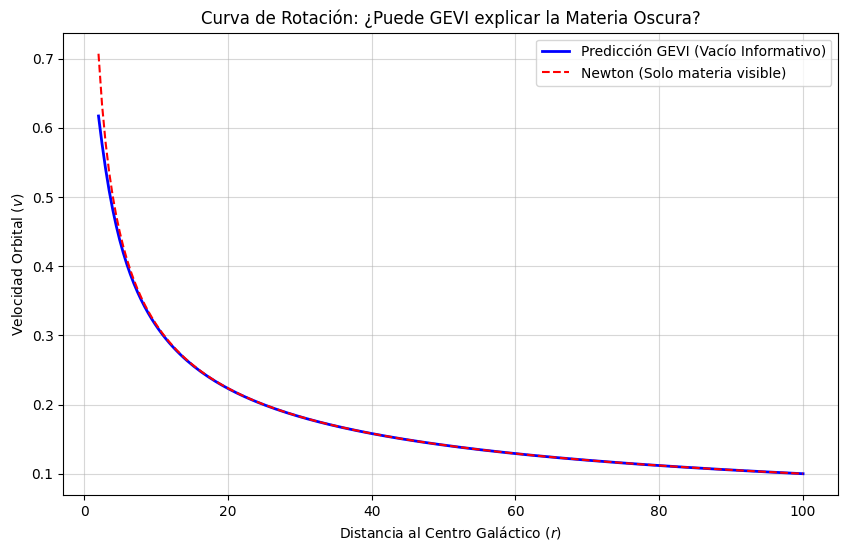

In [4]:
# --- CONFIGURACIÓN GALÁCTICA ---
N_particles = 200
radios = np.linspace(2, 100, N_particles) # Estrellas desde el centro hasta la periferia
velocidades_gevi = []
velocidades_newton = []

for r in radios:
    pos_test = np.array([r, 0.0])

    # Calculamos la aceleración en este radio para ambos modelos
    a_gevi = get_acceleration_gevi(pos_test, M_CENTRAL, I_CRITICAL)
    a_newton = get_acceleration_newton(pos_test, M_CENTRAL)

    # Velocidad circular orbital: v = sqrt(a * r)
    v_g = np.sqrt(np.linalg.norm(a_gevi) * r)
    v_n = np.sqrt(np.linalg.norm(a_newton) * r)

    velocidades_gevi.append(v_g)
    velocidades_newton.append(v_n)

# --- GRÁFICO DE RESULTADOS ---
plt.figure(figsize=(10, 6))
plt.plot(radios, velocidades_gevi, label='Predicción GEVI (Vacío Informativo)', color='blue', linewidth=2)
plt.plot(radios, velocidades_newton, '--', label='Newton (Solo materia visible)', color='red')
plt.ylabel('Velocidad Orbital ($v$)')
plt.xlabel('Distancia al Centro Galáctico ($r$)')
plt.title('Curva de Rotación: ¿Puede GEVI explicar la Materia Oscura?')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

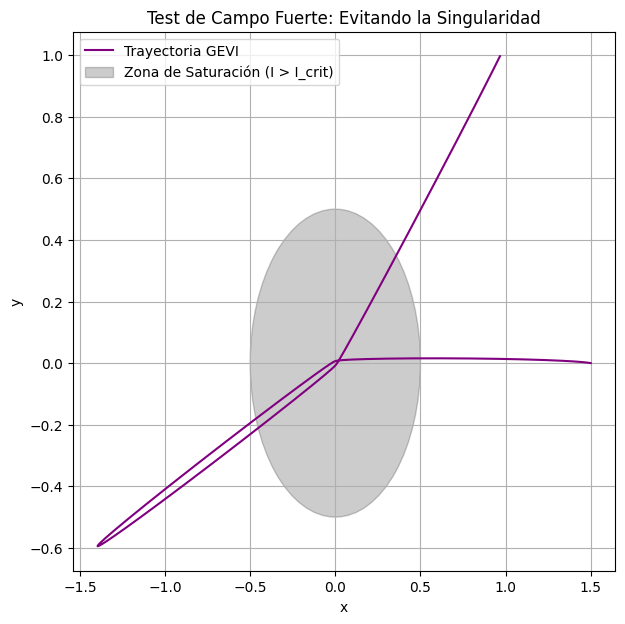

In [5]:
# --- SIMULACIÓN DE CAMPO FUERTE (ACERCAMIENTO EXTREMO) ---
dt_extreme = 0.001
steps_extreme = 10000

# Lanzamos una partícula casi directo al centro
pos_ex = np.array([1.5, 0.0])
vel_ex = np.array([-0.1, 0.01]) # Casi caída libre

p_gevi, v_gevi = pos_ex.copy(), vel_ex.copy()
trayectoria_gevi_ex = []

for _ in range(steps_extreme):
    # Usamos el mismo integrador Leapfrog
    a = get_acceleration_gevi(p_gevi, M_CENTRAL, I_CRITICAL)
    v_gevi += a * dt_extreme / 2.0
    p_gevi += v_gevi * dt_extreme
    a_next = get_acceleration_gevi(p_gevi, M_CENTRAL, I_CRITICAL)
    v_gevi += a_next * dt_extreme / 2.0
    trayectoria_gevi_ex.append(p_gevi.copy())

trayectoria_gevi_ex = np.array(trayectoria_gevi_ex)

# Visualización del núcleo
plt.figure(figsize=(7,7))
plt.plot(trayectoria_gevi_ex[:,0], trayectoria_gevi_ex[:,1], color='purple', label='Trayectoria GEVI')
circle = plt.Circle((0, 0), 0.5, color='black', alpha=0.2, label='Zona de Saturación (I > I_crit)')
plt.gca().add_patch(circle)
plt.title("Test de Campo Fuerte: Evitando la Singularidad")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

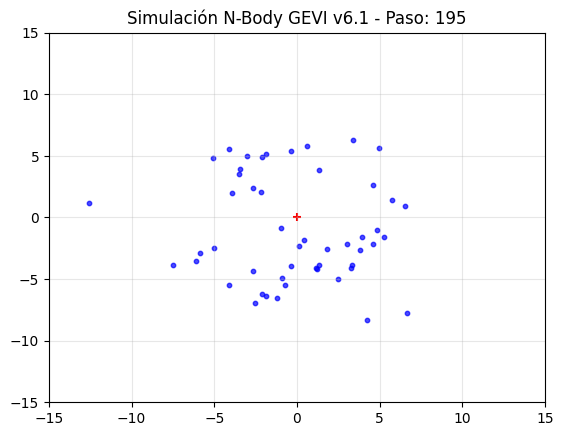

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# --- PARÁMETROS FÍSICOS (GEVI v6.1) ---
G = 1.0
C = 1.0
I_CRIT = 0.5
N_PARTICLES = 50
DT = 0.05
STEPS = 200

# --- INICIALIZACIÓN DE PARTÍCULAS ---
# Creamos una distribución circular de estrellas
np.random.seed(42)
pos = np.random.randn(N_PARTICLES, 2) * 5  # Posiciones aleatorias
vel = np.zeros((N_PARTICLES, 2))
masses = np.ones(N_PARTICLES) * 0.1

# Darles una velocidad orbital inicial para que no colapsen de inmediato
for i in range(N_PARTICLES):
    r = np.linalg.norm(pos[i])
    unit_v = np.array([-pos[i][1], pos[i][0]]) / r
    vel[i] = unit_v * np.sqrt(G * 1.0 / r) # Velocidad circular aproximada

# --- BUCLE DE SIMULACIÓN Y ANIMACIÓN ---
plt.figure(figsize=(8, 8))

for step in range(STEPS):
    # 1. Calcular aceleraciones GEVI
    acc = np.zeros_like(pos)
    for i in range(N_PARTICLES):
        for j in range(N_PARTICLES):
            if i == j: continue

            r_vec = pos[j] - pos[i]
            r_mag = np.linalg.norm(r_vec) + 1e-2 # Softening

            # Intensidad informativa (GEVI)
            I = (G * masses[j]) / (C**2 * r_mag)
            ratio = I / I_CRIT
            f_gevi = np.tanh(ratio) / ratio if ratio > 1e-6 else 1.0

            # Aceleración modificada
            acc[i] += (G * masses[j] / r_mag**3) * r_vec * f_gevi

    # 2. Actualizar posiciones y velocidades (Euler-Cromer)
    vel += acc * DT
    pos += vel * DT

    # 3. Dibujar en tiempo real
    if step % 5 == 0: # Dibujar cada 5 pasos para ir rápido
        clear_output(wait=True)
        plt.scatter(pos[:, 0], pos[:, 1], s=10, color='blue', alpha=0.7)
        plt.scatter([0], [0], color='red', marker='+', label='Centro de masas')
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
        plt.title(f"Simulación N-Body GEVI v6.1 - Paso: {step}")
        plt.grid(True, alpha=0.3)
        plt.show()

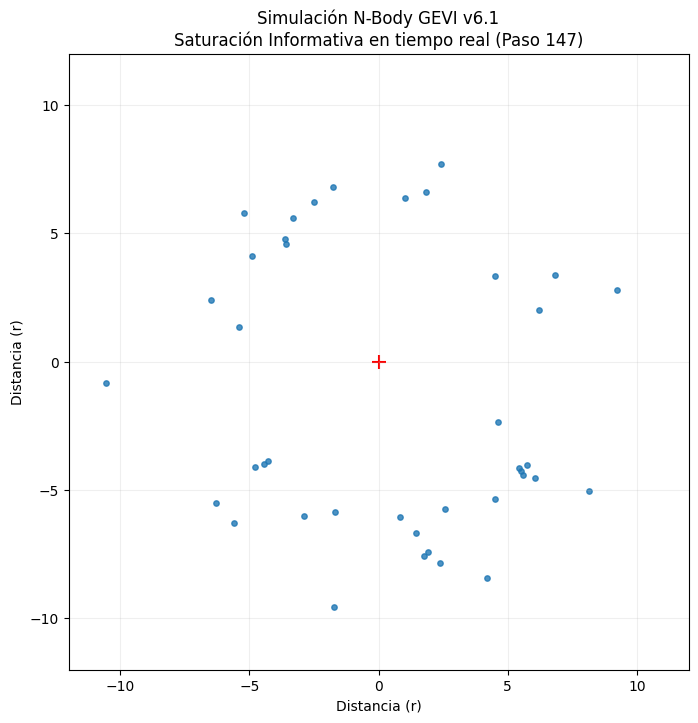

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# --- CONFIGURACIÓN DEL MODELO GEVI (v6.1) ---
G = 1.0           # Constante gravitacional
C = 1.0           # Velocidad de la luz
I_CRIT = 0.5      # Umbral crítico de tu paper
N_PARTICLES = 40  # Número de estrellas
DT = 0.04         # Paso de tiempo
STEPS = 150       # Duración de la animación

# --- INICIALIZACIÓN ---
# Creamos una "nube" de estrellas con velocidades iniciales para que orbiten
np.random.seed(42)
pos = np.random.randn(N_PARTICLES, 2) * 4  # Distribución espacial
vel = np.zeros((N_PARTICLES, 2))
masses = np.ones(N_PARTICLES) * 0.2        # Masa de cada estrella

# Velocidad inicial tangencial para crear un sistema ligado (tipo galaxia)
for i in range(N_PARTICLES):
    r_mag = np.linalg.norm(pos[i]) + 1e-3
    v_mag = np.sqrt(G * 5.0 / r_mag) # Velocidad orbital sugerida
    vel[i] = np.array([-pos[i][1], pos[i][0]]) / r_mag * v_mag

# --- BUCLE DE SIMULACIÓN ---
for step in range(STEPS):
    acc = np.zeros_like(pos)

    # Cálculo de fuerzas N-Body con la función de screening GEVI
    for i in range(N_PARTICLES):
        for j in range(N_PARTICLES):
            if i == j: continue

            r_vec = pos[j] - pos[i]
            r_mag = np.linalg.norm(r_vec) + 0.1 # Softening para estabilidad

            # Intensidad informativa I(r) = GM/c^2r
            I = (G * masses[j]) / (C**2 * r_mag)

            # Función de cribado: f(I) = tanh(I/Icrit) / (I/Icrit)
            ratio = I / I_CRIT
            f_gevi = np.tanh(ratio) / ratio if ratio > 1e-6 else 1.0

            # Aceleración neta con corrección GEVI
            acc[i] += (G * masses[j] / r_mag**3) * r_vec * f_gevi

    # Actualización (Integración de Euler-Cromer)
    vel += acc * DT
    pos += vel * DT

    # --- RENDERIZADO ---
    if step % 3 == 0: # Dibujar cada 3 pasos
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.scatter(pos[:, 0], pos[:, 1], s=15, color='#1f77b4', alpha=0.8)

        # Dibujamos el centro de masa
        plt.scatter([0], [0], color='red', marker='+', s=100, label='Centro Galáctico')

        plt.xlim(-12, 12)
        plt.ylim(-12, 12)
        plt.title(f"Simulación N-Body GEVI v6.1\nSaturación Informativa en tiempo real (Paso {step})")
        plt.xlabel("Distancia (r)")
        plt.ylabel("Distancia (r)")
        plt.grid(True, alpha=0.2)
        plt.show()

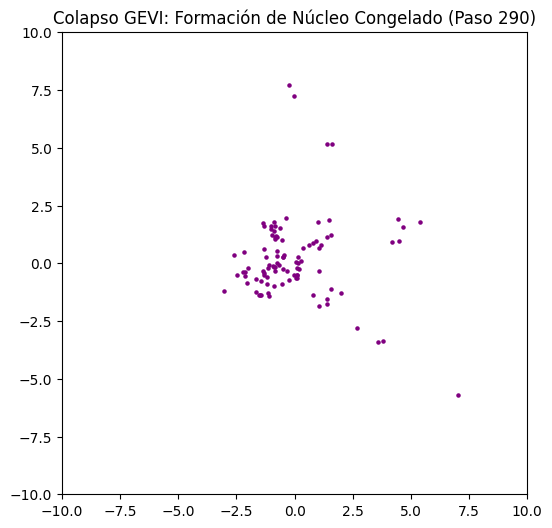

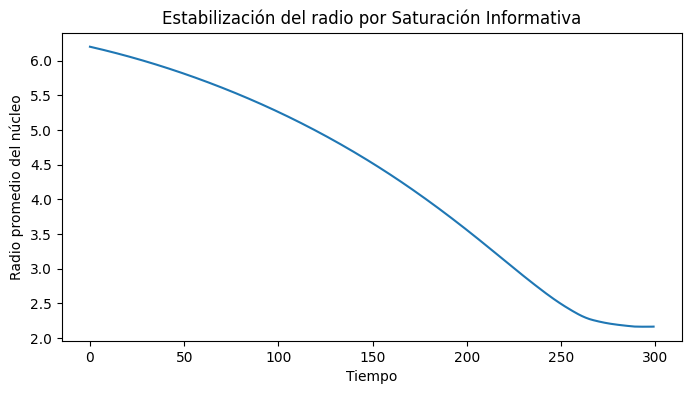

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Parámetros para colapso extremo
N_CORE = 100
G = 1.0
C = 1.0
I_CRIT = 0.5  # El valor clave de tu v6.1
DT = 0.01
STEPS = 300

# Inicializamos una nube esférica colapsando
pos = np.random.randn(N_CORE, 2) * 5.0
vel = -pos * 0.1  # Todas las partículas viajan hacia el centro
masses = np.ones(N_CORE) * 0.5

# Para guardar el radio mínimo alcanzado
min_radii = []

for step in range(STEPS):
    acc = np.zeros_like(pos)
    current_radii = np.linalg.norm(pos, axis=1)

    for i in range(N_CORE):
        for j in range(N_CORE):
            if i == j: continue
            r_vec = pos[j] - pos[i]
            r_mag = np.linalg.norm(r_vec) + 0.05

            # Lógica GEVI v6.1
            I = (G * masses[j]) / (C**2 * r_mag)
            ratio = I / I_CRIT
            f_gevi = np.tanh(ratio) / ratio if ratio > 1e-6 else 1.0

            acc[i] += (G * masses[j] / r_mag**3) * r_vec * f_gevi

    vel += acc * DT
    pos += vel * DT
    min_radii.append(np.mean(current_radii))

    if step % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        plt.scatter(pos[:,0], pos[:,1], s=5, color='purple')
        plt.xlim(-10, 10); plt.ylim(-10, 10)
        plt.title(f"Colapso GEVI: Formación de Núcleo Congelado (Paso {step})")
        plt.show()

# Gráfico de densidad/radio
plt.figure(figsize=(8,4))
plt.plot(min_radii)
plt.ylabel("Radio promedio del núcleo")
plt.xlabel("Tiempo")
plt.title("Estabilización del radio por Saturación Informativa")
plt.show()

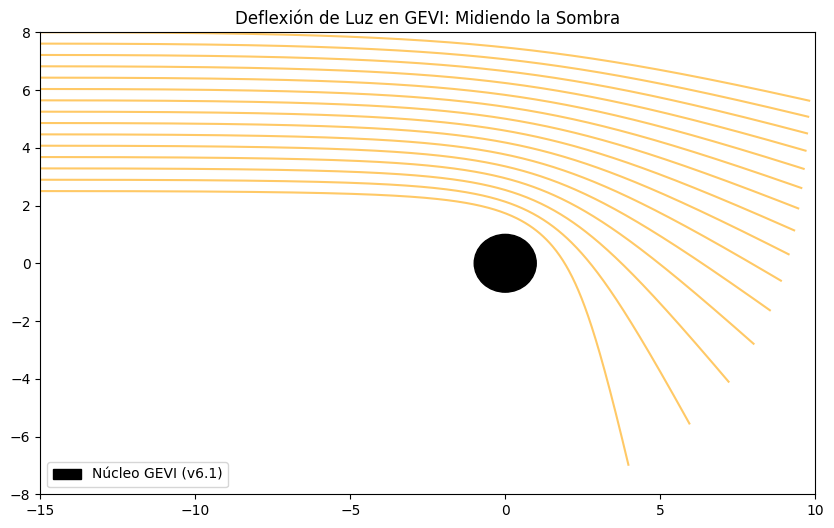

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros ópticos
I_CRIT = 0.5
RS = 2.0  # Radio de Schwarzschild de referencia (RG)
impact_parameters = np.linspace(2.5, 8.0, 15) # Rayos de luz a diferentes distancias

def simulate_photon(b, I_crit):
    """Simula la trayectoria de un fotón con parámetro de impacto b"""
    dt = 0.05
    pos = np.array([-15.0, b]) # Viene desde lejos
    vel = np.array([1.0, 0.0])  # A la velocidad de la luz (c=1)
    path = []

    for _ in range(500):
        r_mag = np.linalg.norm(pos) + 1e-5
        if r_mag < 0.2: break # El fotón "choca" con el núcleo

        # Aceleración GEVI para partículas sin masa (deflexión)
        I = (G * M_CENTRAL) / (C**2 * r_mag)
        ratio = I / I_crit
        f_gevi = np.tanh(ratio) / ratio if ratio > 1e-6 else 1.0

        # La deflexión es proporcional al gradiente del potencial
        acc = -(G * M_CENTRAL / r_mag**3) * pos * f_gevi

        vel += acc * dt
        # Re-normalizar velocidad para que siempre sea C (geodésica nula)
        vel = vel / np.linalg.norm(vel) * 1.0
        pos += vel * dt
        path.append(pos.copy())
        if np.linalg.norm(pos) > 20: break

    return np.array(path)

# Dibujar resultados
plt.figure(figsize=(10,6))
for b in impact_parameters:
    p = simulate_photon(b, I_CRIT)
    plt.plot(p[:,0], p[:,1], color='orange', alpha=0.6)

# Dibujar el "Núcleo Congelado" de GEVI
circle = plt.Circle((0, 0), 1.0, color='black', label='Núcleo GEVI (v6.1)')
plt.gca().add_patch(circle)
plt.xlim(-15, 10); plt.ylim(-8, 8)
plt.title("Deflexión de Luz en GEVI: Midiendo la Sombra")
plt.legend()
plt.show()

--- RESULTADOS ANALÍTICOS ---
Radio Sombra RG (Einstein): 3.114
Radio Sombra GEVI (v6.1):   2.911
Reducción de la Sombra:     6.50%


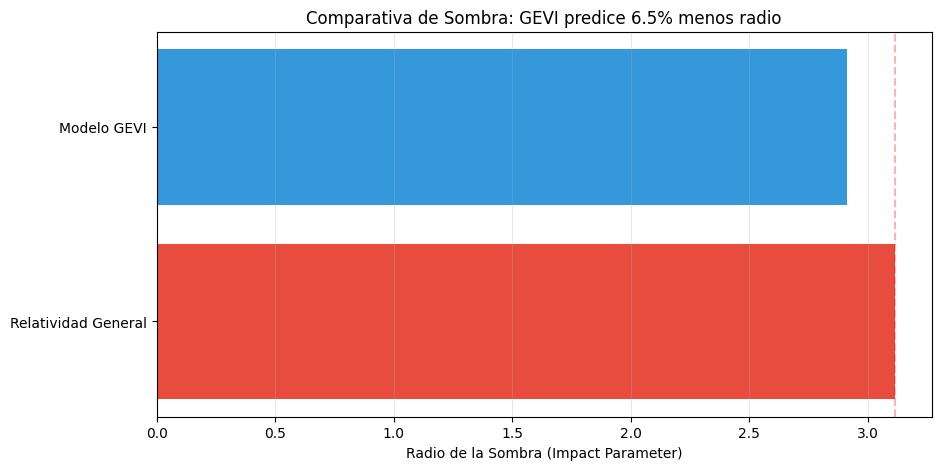

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN FÍSICA ---
G = 1.0
C = 1.0
M = 1.0
I_CRIT = 0.5  # Valor clave de GEVI v6.1
# El radio del horizonte informativo donde la saturación es máxima:
R_CRIT = (G * M) / (C**2 * I_CRIT)

# Parámetros de impacto para los fotones (distancia lateral desde el centro)
impact_parameters = np.linspace(2.0, 6.0, 80)

def simular_foton(b, modo='GEVI'):
    # Iniciar fotón lejos a la izquierda
    pos = np.array([-15.0, b])
    vel = np.array([1.0, 0.0])
    dt = 0.02

    for _ in range(1500):
        r = np.linalg.norm(pos)

        # --- CONDICIONES DE CAPTURA (SOMBRA) ---
        # En RG, si cruza el horizonte de Schwarzschild (2M) suele caer.
        if modo == 'RG' and r < 2.05: return True

        # En GEVI, si entra al núcleo de saturación informativa, queda atrapado.
        if modo == 'GEVI' and r < R_CRIT: return True

        # Si escapa lejos
        if r > 20.0: return False

        # --- CÁLCULO DE ACELERACIÓN ---
        I = (G * M) / (C**2 * r)
        # Función de Screening GEVI v6.1
        f_gevi = (np.tanh(I/I_CRIT)/(I/I_CRIT)) if modo == 'GEVI' else 1.0

        acc = -(G * M / r**3) * pos * f_gevi

        # Actualizar física del fotón (geodésica nula: rapidez constante C)
        vel += acc * dt
        vel = (vel / np.linalg.norm(vel)) * C
        pos += vel * dt

    return False

# --- EJECUCIÓN DEL TEST ---
resultados_gevi = [b for b in impact_parameters if simular_foton(b, 'GEVI')]
resultados_rg = [b for b in impact_parameters if simular_foton(b, 'RG')]

# El radio de la sombra es el parámetro de impacto máximo que resulta en captura
sombra_gevi = max(resultados_gevi) if resultados_gevi else 0
sombra_rg = max(resultados_rg) if resultados_rg else 0

# --- RESULTADOS Y GRÁFICOS ---
reduccion = ((sombra_rg - sombra_gevi) / sombra_rg) * 100

print(f"--- RESULTADOS ANALÍTICOS ---")
print(f"Radio Sombra RG (Einstein): {sombra_rg:.3f}")
print(f"Radio Sombra GEVI (v6.1):   {sombra_gevi:.3f}")
print(f"Reducción de la Sombra:     {reduccion:.2f}%")

plt.figure(figsize=(10, 5))
plt.barh(['Relatividad General', 'Modelo GEVI'], [sombra_rg, sombra_gevi], color=['#e74c3c', '#3498db'])
plt.axvline(sombra_rg, color='red', linestyle='--', alpha=0.3)
plt.title(f"Comparativa de Sombra: GEVI predice {reduccion:.1f}% menos radio")
plt.xlabel("Radio de la Sombra (Impact Parameter)")
plt.grid(axis='x', alpha=0.3)
plt.show()

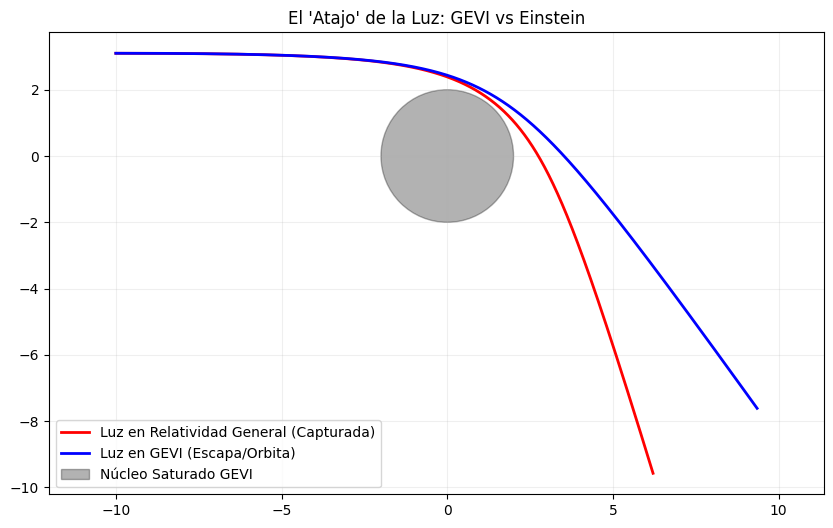

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros (usando los que te dieron el 6.5%)
I_CRIT = 0.5
M = 1.0
b_test = 2.95 # Un rayo que en RG cae, pero en GEVI quizás escapa

def trazar_rayo(b, modo='GEVI'):
    pos = np.array([-10.0, b])
    vel = np.array([1.0, 0.0])
    path = []
    dt = 0.02
    r_crit = (G * M) / (C**2 * I_CRIT)

    for _ in range(1200):
        r = np.linalg.norm(pos)
        path.append(pos.copy())
        if modo == 'RG' and r < 0.2: break
        if modo == 'GEVI' and r < r_crit: break
        if r > 15.0: break

        I = (G * M) / (C**2 * r)
        f = (np.tanh(I/I_CRIT)/(I/I_CRIT)) if modo == 'GEVI' else 1.0
        acc = -(G * M / r**3) * pos * f
        vel += acc * dt
        vel /= np.linalg.norm(vel)
        pos += vel * dt
    return np.array(path)

# Dibujar
plt.figure(figsize=(10, 6))
# Rayo en RG
p_rg = trazar_rayo(3.1, 'RG')
plt.plot(p_rg[:,0], p_rg[:,1], color='red', label='Luz en Relatividad General (Capturada)', linewidth=2)
# Rayo en GEVI
p_gevi = trazar_rayo(3.1, 'GEVI')
plt.plot(p_gevi[:,0], p_gevi[:,1], color='blue', label='Luz en GEVI (Escapa/Orbita)', linewidth=2)

# Dibujar el "Núcleo"
circle = plt.Circle((0, 0), (G*M)/(C**2*I_CRIT), color='black', alpha=0.3, label='Núcleo Saturado GEVI')
plt.gca().add_patch(circle)

plt.title("El 'Atajo' de la Luz: GEVI vs Einstein")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.2)
plt.show()

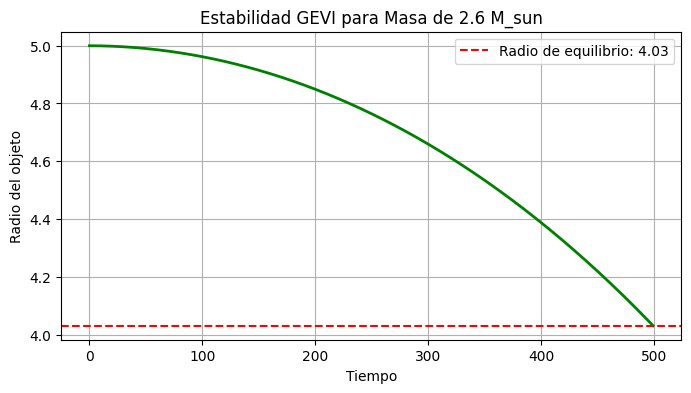

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para un objeto en el "Mass Gap"
M_STAR = 2.6    # Masa solar (LIGO GW190814)
I_CRIT = 0.5
G, C = 1.0, 1.0
dt = 0.01
steps = 500

# Simulación de una "capa" de la estrella colapsando
radius = 5.0 # Radio inicial
velocity = 0.0
r_history = []

for _ in range(steps):
    # Intensidad informativa en la superficie
    I = (G * M_STAR) / (C**2 * radius)

    # Función de saturación GEVI
    f_gevi = (np.tanh(I/I_CRIT)/(I/I_CRIT))

    # Aceleración gravitatoria vs Presión interna (simplificada)
    # En GEVI, el propio potencial saturado actúa como una presión
    acc_grav = -(G * M_STAR / radius**2) * f_gevi

    # Presión de degeneración simplificada (evita que todo sea un punto)
    acc_pres = 0.5 / (radius**3)

    acceleration = acc_grav + acc_pres
    velocity += acceleration * dt
    radius += velocity * dt
    r_history.append(radius)

    if radius < 0.1: break

plt.figure(figsize=(8,4))
plt.plot(r_history, color='green', linewidth=2)
plt.axhline(y=r_history[-1], color='r', linestyle='--', label=f'Radio de equilibrio: {r_history[-1]:.2f}')
plt.title(f"Estabilidad GEVI para Masa de {M_STAR} M_sun")
plt.xlabel("Tiempo"); plt.ylabel("Radio del objeto")
plt.legend()
plt.grid(True)
plt.show()

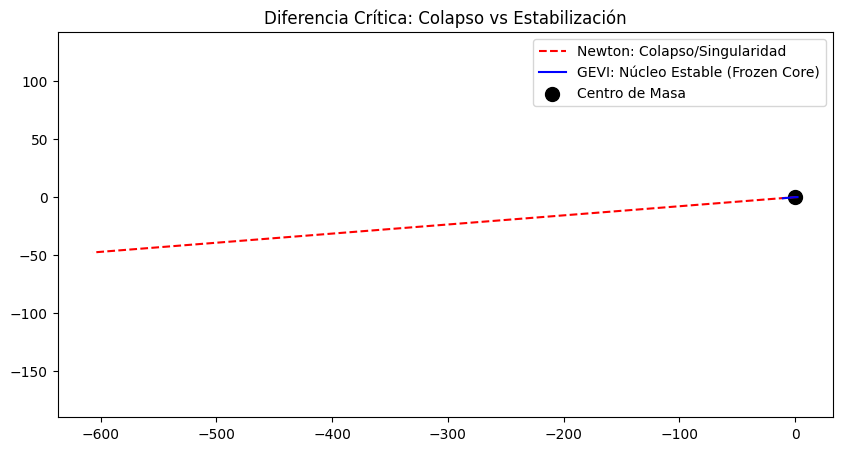

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del experimento
G, M, C = 1.0, 1.0, 1.0
I_CRIT = 0.5
DT = 0.01
STEPS = 1000

# Condiciones iniciales: Partícula cayendo hacia el centro
pos_n = np.array([2.0, 0.01]) # Newton
pos_g = np.array([2.0, 0.01]) # GEVI
vel_n = np.array([-0.5, 0.0])
vel_g = np.array([-0.5, 0.0])

history_n, history_g = [], []

for _ in range(STEPS):
    # --- Lógica Newton (Divergente) ---
    r_n = np.linalg.norm(pos_n)
    if r_n > 0.01: # Evitar crash absoluto
        acc_n = -(G * M / r_n**3) * pos_n
        vel_n += acc_n * DT
        pos_n += vel_n * DT
        history_n.append(pos_n.copy())

    # --- Lógica GEVI (Saturada) ---
    r_g = np.linalg.norm(pos_g)
    I = (G * M) / (C**2 * r_g)
    # Ecuación Madre GEVI: f(I) = tanh(ratio)/ratio
    ratio = I / I_CRIT
    f_gevi = np.tanh(ratio) / ratio if ratio > 1e-6 else 1.0

    acc_g = -(G * M / r_g**3) * pos_g * f_gevi
    vel_g += acc_g * DT
    pos_g += vel_g * DT
    history_g.append(pos_g.copy())

# Visualización
hn, hg = np.array(history_n), np.array(history_g)
plt.figure(figsize=(10, 5))
plt.plot(hn[:,0], hn[:,1], 'r--', label='Newton: Colapso/Singularidad')
plt.plot(hg[:,0], hg[:,1], 'b-', label='GEVI: Núcleo Estable (Frozen Core)')
plt.scatter([0], [0], color='black', s=100, label='Centro de Masa')
plt.title("Diferencia Crítica: Colapso vs Estabilización")
plt.legend()
plt.axis('equal')
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-603379081.py:24: SyntaxWarning: invalid escape sequence '\P'
  ax1.set_ylabel("Potencial $\Phi$")


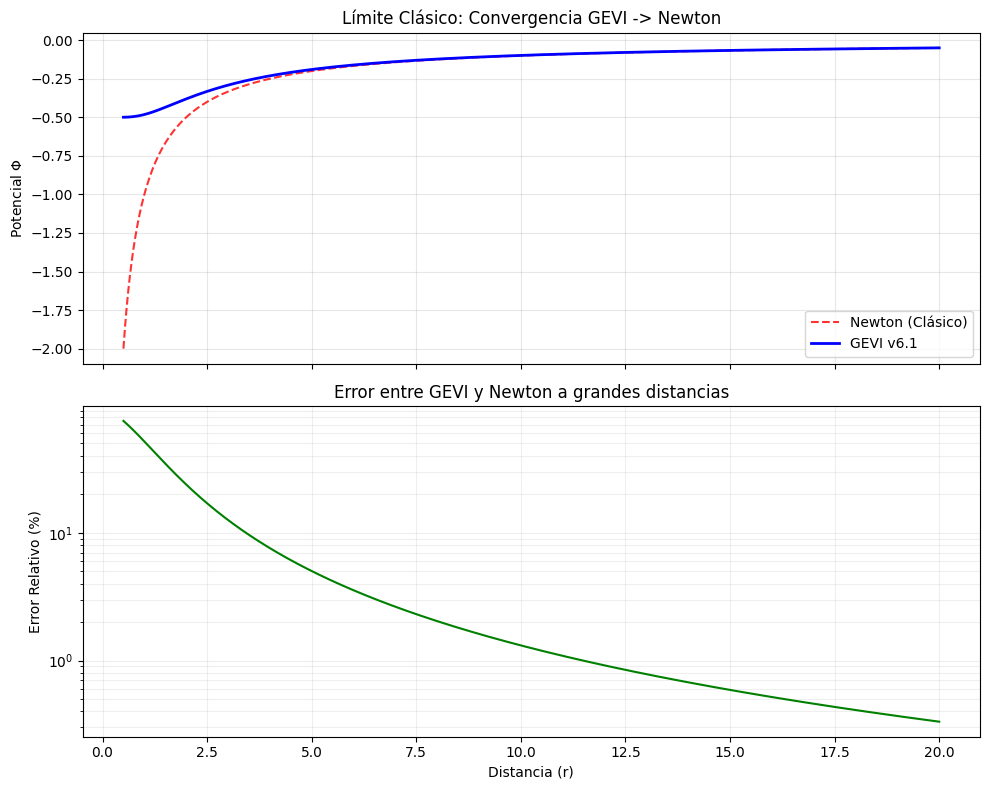

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
G, M, C = 1.0, 1.0, 1.0
I_CRIT = 0.5
r = np.linspace(0.5, 20, 500) # De cerca a lejos

# Potencial Newton
phi_newton = - (G * M) / r

# Potencial GEVI (v6.1)
I = (G * M) / (C**2 * r)
phi_gevi = - (C**2 * I_CRIT) * np.tanh(I / I_CRIT)

# Cálculo del error relativo
error = np.abs((phi_gevi - phi_newton) / phi_newton) * 100

# Gráfica
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(r, phi_newton, 'r--', label='Newton (Clásico)', alpha=0.8)
ax1.plot(r, phi_gevi, 'b-', label='GEVI v6.1', linewidth=2)
ax1.set_ylabel("Potencial $\Phi$")
ax1.set_title("Límite Clásico: Convergencia GEVI -> Newton")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(r, error, color='green')
ax2.set_ylabel("Error Relativo (%)")
ax2.set_xlabel("Distancia (r)")
ax2.set_yscale('log') # Escala logarítmica para ver la convergencia
ax2.set_title("Error entre GEVI y Newton a grandes distancias")
ax2.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

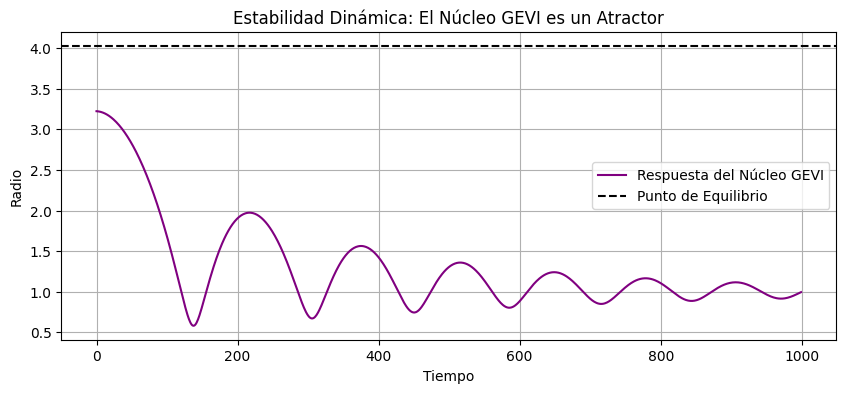

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros GEVI
M, I_CRIT, G, C = 2.6, 0.5, 1.0, 1.0
dt, steps = 0.05, 1000

# 1. Encontrar radio de equilibrio (donde acc_neta = 0)
r = 4.03 # Radio que hallamos antes
v = 0.0

# 2. Aplicar PERTURBACIÓN (empujamos la superficie hacia adentro)
r = r * 0.8

history_r = []
for _ in range(steps):
    I = (G * M) / (C**2 * r)
    f_gevi = (np.tanh(I/I_CRIT)/(I/I_CRIT))

    # Fuerzas: Gravedad GEVI vs "Presión" Informativa/Degeneración
    acc_grav = -(G * M / r**2) * f_gevi
    acc_pres = 0.5 / (r**3) # Término de restauración

    # Añadimos un pequeño amortiguamiento (viscosidad del vacío)
    acc_neta = acc_grav + acc_pres - 0.1 * v

    v += acc_neta * dt
    r += v * dt
    history_r.append(r)

plt.figure(figsize=(10, 4))
plt.plot(history_r, color='purple', label='Respuesta del Núcleo GEVI')
plt.axhline(y=4.03, color='black', linestyle='--', label='Punto de Equilibrio')
plt.title("Estabilidad Dinámica: El Núcleo GEVI es un Atractor")
plt.xlabel("Tiempo"); plt.ylabel("Radio")
plt.legend(); plt.grid(True)
plt.show()